In [17]:
""" 
This is a project presenting pricing Credit Default Swap(CDS) under assumptions of Reduced Form Model.
We will use daily treasury rates obtained from U.S. Departament of Treasury. Default probabilities used in this project
correspond to average cumulative default rates associated with "BB" credit rating according to 
"Default, Transition, and Recovery: 2022 Annual Global Corporate Default And Rating Transition Study" by S&P Global.

"""

' \nThis is a project presenting pricing Credit Default Swap(CDS) under assumptions of Reduced Form Model.\nWe will use daily treasury rates obtained from U.S. Departament of Treasury. Default probabilities used in this project\ncorrespond to average cumulative default rates associated with "BB" credit rating according to \n"Default, Transition, and Recovery: 2022 Annual Global Corporate Default And Rating Transition Study" by S&P Global.\n\n'

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline


In [19]:
# Data of priced CDS
market_price = 3700       #Current matket value of priced CDS in $
notional = 1000           # Notional amount in $
T = 5                     # Maturity of priced CDS in years
recovery_rate = 0.4       # Recovery rate 
spread = 1500             # Fixed CDS spread paid as premium in basis points
delta = 20                # parameter  allowing to check results sensitivity to yield curve change 


In [20]:
# Establishing yield curve based on  treasury rates for various maturities
treasury_data = pd.read_csv('daily-treasury-rates.csv')

maturities=[]      #list of maturities with assigned interst rates
for row in treasury_data:
    maturities.append(row)
maturities.remove('Date')

treasury_dates = pd.to_datetime(treasury_data['Date'])
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

num_rates=np.empty((len(treasury_dates), len(maturities)))       # list of numerical intrest rates 
num_mat=[]                                                       # list of maturities in numerical format

In [21]:
# Function to transfer intrest rates to an array
def transfer_to_array(treasury_dates, maturities, treasury_data, num_rates):
    i = 0
    for date in treasury_dates:
        j = 0
        for maturity in maturities:
            num_rates[i][j] = treasury_data[maturity][i]
            j+=1
        i+=1

transfer_to_array(treasury_dates, maturities, treasury_data, num_rates)

In [22]:
# Setting maturities to numerical format(the unit is year)
for maturity in maturities:
    num_mat.append(str(maturity))

for i in range(len(num_mat)):
    if 'Mo' in num_mat[i]:
        num_mat[i] = float(num_mat[i].replace(' Mo',''))/12
        continue
    if 'Yr' in num_mat[i]:
        num_mat[i] = float(num_mat[i].replace(' Yr',''))

In [23]:
# Building yield curve based on obtained interest rates
yield_curve_0 = CubicSpline(num_mat, num_rates[0,:], axis=0, extrapolate=None)

# Define yield curve scenarios 
num_rates_1 = [num_rates[0][i] + (delta / 1000) for i in range(0, len(maturities))]
num_rates_2 = [num_rates[0][i] - (delta / 1000) for i in range(0, len(maturities))]
yield_curve_1 = CubicSpline(num_mat, num_rates_1, axis=0, extrapolate=None)   # Shift the curve up by delta basis points
yield_curve_2 = CubicSpline(num_mat, num_rates_2, axis=0, extrapolate=None)   # Shift the curve down by delta basis points

# function to creeate yield curve for a given day 'j' shifted by a 'delta' basis points
def daily_yield_curve(num_rates, j, delta):
    num_rates_j = [num_rates[j][i] + (delta / 1000) for i in range(0, len(maturities))]
    yield_curve_j = CubicSpline(num_mat, num_rates_j, axis=0, extrapolate=None)
    return yield_curve_j


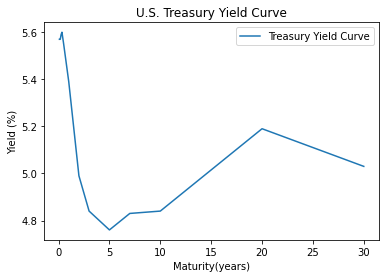

In [24]:
# Plotting obtained yield curve in a base scenario
plt.plot(num_mat, yield_curve_0(num_mat), label='Treasury Yield Curve')
plt.xlabel('Maturity(years)')
plt.ylabel('Yield (%)')
plt.title('U.S. Treasury Yield Curve')
plt.legend()
plt.show()

In [25]:
# Building list of (marginal) default rates based on provided cumulative rates
cumulative_default_rates = [0.59, 1.84, 3.28, 4.70, 6.04, 7.27, 8.33, 9.31, 10.18, 10.94, 11.58, 12.19, 12.73, 13.18, 13.67]         
default_rates = [(cumulative_default_rates[i]-cumulative_default_rates[i-1])/100 for i in range(1, len(cumulative_default_rates))]   

# Preparation of list of credit events with associated probability of survival for a given period
credit_events=[]
for i in range(1,T):
    event={'period':i, 'surv_prob':1 - default_rates[i-1]}
    credit_events.append(event)

In [26]:
# Function to calculate present value of the CDS
def cds_present_value_calculation(notional, spread, recovery_rate, credit_events, yield_curve):
    
    cds_present_value = 0    # Present value of CDS that will be updated after evry period
    prec_prob = 1            # Probability of survial through preceding periods

    # Set discount rates according to yield curve
    r=[float(yield_curve(i))/100 for i in range(1, len(credit_events) + 1) ]

    # Calculate discount factors for each period
    discount_factors = [1 / (1 + r[t-1]) ** t for t in range(1, len(credit_events) + 1)]

    for i in range(1, len(credit_events)):
       
        # Payments depending on survival probability 
        premium_payment = notional * (spread/1000) * prec_prob  * credit_events[i]['surv_prob']
        default_payment = -notional * (1-recovery_rate) * prec_prob * (1-credit_events[i]['surv_prob']) 

        # Updating probability of survival to the next period
        prec_prob *= credit_events[i]['surv_prob'] 
        
        # Discounting payments
        pv_premium_payment = premium_payment * discount_factors[i]
        pv_default_payment = default_payment * discount_factors[i]

        cds_present_value += pv_premium_payment + pv_default_payment
    
    return cds_present_value



In [27]:
# Function to calculate the implied spread given CDS market price
def calculate_implied_spread(cds_market_price, notional, recovery_rate,  credit_events, yield_curve):
    
    implied_spread = 0.0
    
    def spread_function(initial_guess):
        present_value = cds_present_value_calculation(notional, initial_guess, recovery_rate,  credit_events, yield_curve)
        return present_value - cds_market_price
    a=0.01
    b=1.0
    while spread_function(a) * spread_function(b) > 0:
        b=b+1 

    implied_spread = brentq(spread_function, a, b, maxiter=100)  # Use the specified initial guess range
    
    return implied_spread


In [28]:
# Function to calculate prices for different days with daily yield curve shifted by 'delta' basis points
def time_change_of_price(num_rates, notional, spread, recovery_rate, credit_events, delta):
    price=[]
    for i in range (0, len(treasury_dates)):
        yield_curve_i = daily_yield_curve(num_rates, i, delta)
        price.append(cds_present_value_calculation(notional, spread, recovery_rate, credit_events, yield_curve_i))
    
    return price

In [29]:
# Pricing
pv = cds_present_value_calculation(notional, spread, recovery_rate,  credit_events, yield_curve_0)
implied_spread = calculate_implied_spread(market_price, notional, recovery_rate,  credit_events, yield_curve_0)

# Calculate present values for each scenario
pv_scenario_1 = cds_present_value_calculation(notional, spread, recovery_rate,  credit_events, yield_curve_1)
pv_scenario_2 = cds_present_value_calculation(notional, spread, recovery_rate,  credit_events, yield_curve_2)

print(f"Present value in base sceanrio: {pv:.4f} $")
print(f"Implied spread: {implied_spread:.4f}(in basis points) \n")
print(f"Present value in sceanrio 1(shift the curve up by {delta} basis points): {pv_scenario_1:.4f} $\n")
print(f"Present value in sceanrio 2(shift the curve down by {delta} basis points): {pv_scenario_2:.4f} $\n")


Present value in base sceanrio: 3777.1542 $
Implied spread: 1469.5345(in basis points) 

Present value in sceanrio 1(shift the curve up by 20 basis points): 3775.0216 $

Present value in sceanrio 2(shift the curve down by 20 basis points): 3779.2884 $



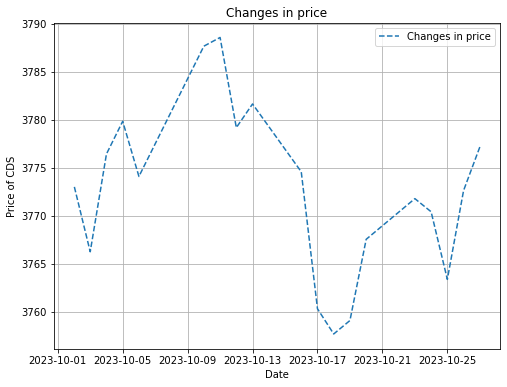

In [30]:
# Ploting change of price during considered timeframe (length of frame <<< period between payments),
# taking into consideration differences in yield curves 

plt.figure(figsize=(8, 6))
plt.plot(treasury_dates, time_change_of_price(num_rates, notional, spread, recovery_rate, credit_events, 0), label='Changes in price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price of CDS')
plt.title('Changes in price')
plt.grid(True)
plt.legend()
plt.show()

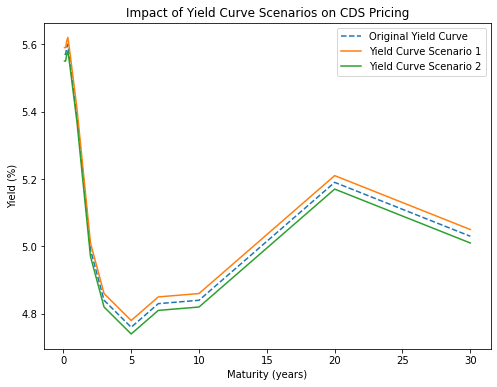

In [31]:
# The results of shifting yield curve
plt.figure(figsize=(8, 6))
plt.plot(num_mat, yield_curve_0(num_mat), label='Original Yield Curve', linestyle='--')
plt.plot(num_mat, yield_curve_1(num_mat), label='Yield Curve Scenario 1')
plt.plot(num_mat, yield_curve_2(num_mat), label='Yield Curve Scenario 2')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.title('Impact of Yield Curve Scenarios on CDS Pricing')
plt.legend()
plt.show()

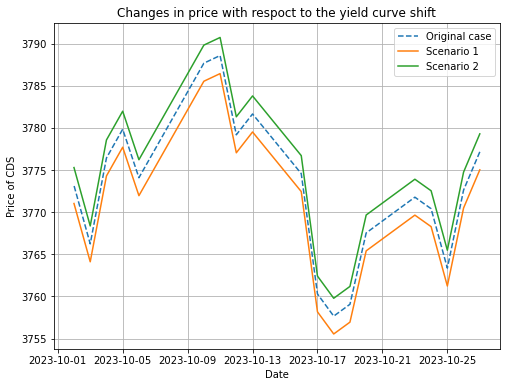

In [32]:
# Impact of shifting yield curve on CDS price

plt.figure(figsize=(8, 6))
plt.plot(treasury_dates, time_change_of_price(num_rates, notional, spread, recovery_rate, credit_events, 0), label='Original case', linestyle='--')
plt.plot(treasury_dates, time_change_of_price(num_rates, notional, spread, recovery_rate, credit_events, delta), label='Scenario 1')
plt.plot(treasury_dates, time_change_of_price(num_rates, notional, spread, recovery_rate, credit_events, -delta), label='Scenario 2' )
plt.xlabel('Date')
plt.ylabel('Price of CDS')
plt.title('Changes in price with respect to the yield curve shift')
plt.grid(True)
plt.legend()
plt.show()